In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from PIL import Image
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from VAE import VAEConv
import matplotlib.pyplot as plt
import numpy as np
import random

## Data

In [3]:
Metadata_dir = '/content/drive/MyDrive/Project Data Science/'

In [4]:
df = pd.read_csv(Metadata_dir + "Health_VS_Calc_And_Mass.csv")
df.head()

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split,Health
0,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,4e3a578fe535ea4f5258d3f7f4419db8,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2355.139893,1731.640015,2482.979980,1852.750000,training,1
1,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,dac39351b0f3a8c670b7f8dc88029364,R,MLO,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2386.679932,1240.609985,2501.800049,1354.040039,training,1
2,5683854eafabc34f6d854000d2ac6c2d,4ac33111294b83d43537cb8604b0808c,2f944efb1cb9579442df2d7fe6a579b7,L,CC,3518,2800,BI-RADS 3,DENSITY C,['Mass'],BI-RADS 3,142.899002,2171.810059,439.584991,2403.370117,test,1
3,5683854eafabc34f6d854000d2ac6c2d,4ac33111294b83d43537cb8604b0808c,7385e8cf7b29764525c81de4aa1aebe4,L,MLO,3518,2800,BI-RADS 3,DENSITY C,['Mass'],BI-RADS 3,142.899002,2045.170044,417.876007,2265.879883,test,1
4,89524e5f372d9aff8ed43b4ef29c1435,0838a0b906894e0cc06c993426a2d143,5a94dd668eaa9865b907450c37db6ecc,R,CC,3518,2800,BI-RADS 3,DENSITY C,['Mass'],BI-RADS 3,1988.060059,1793.739990,2139.909912,1967.459961,training,1


In [5]:
df_MLO = df[df['view_position'] == 'MLO']
df_MLO = df_MLO[df_MLO['Health'] == 0]
df_train = df_MLO[df_MLO['split'] == 'training']
df_train = df_train[df_train['laterality'] == 'R']
df_train = df_train.sample(1000)
df_train.head()

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split,Health
7670,67266921817ebbfa1b88dde91b588f5f,821b1930e9776663ac5fe2fc82197d4c,24e7e6f091714da4e13f8e4f6b8dae4d,R,MLO,3518,2800,BI-RADS 1,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,training,0
9840,60577140bc7ea8da15f0001ee557f94f,1d8f2df0d39c38adb758c824df2f0967,8a0442e17cc384ccb8e27f799011f08d,R,MLO,3518,2800,BI-RADS 2,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,training,0
10847,d12d2142617d3ce2bc21fc399de6dd47,b49b2383b9d08a70cbc308e1db6a18c1,6eaad523ebd34bcc69ec976bfdb84f2c,R,MLO,3518,2800,BI-RADS 1,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,training,0
4661,21d31e167e3a7ed6338cb3b054616501,7efee404e9d124287a766fb9319e3593,1afbf9c8d210d3746752f3c3d94fb26f,R,MLO,3518,2800,BI-RADS 2,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,training,0
10576,259c3a22edb64244a05eb2931d49cfd6,040b38d5e9068757775daeaeeced5350,ddec9917840ce48888751a7cbf1be6dc,R,MLO,3518,2800,BI-RADS 1,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,training,0


In [6]:
df_train.shape

(1000, 17)

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame with 'image_id' and 'series_id'.
            image_dir (str): Root directory where images are stored.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get the image path from the dataframe
        image_id = self.dataframe.iloc[idx]['image_id']
        series_id = self.dataframe.iloc[idx]['study_id']

        # Construct the full path to the image
        img_path = os.path.join(self.image_dir, str(series_id), str(image_id) + '.png')

        # Load the image (assuming grayscale)
        image = Image.open(img_path).convert('L')  # 'L' mode for grayscale

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        return image

In [7]:
img_size = 128
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),  # Example resize
    transforms.ToTensor()          # Convert to tensor
    ])

In [8]:
image_dir = Metadata_dir + 'Processed_Images'
dataset = CustomImageDataset(dataframe=df_train, image_dir=image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

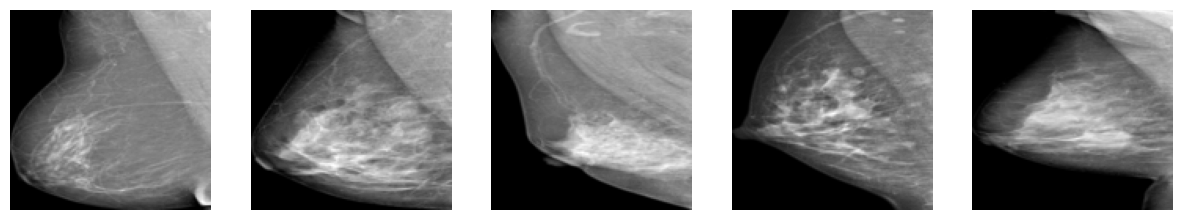

In [9]:
dataiter = iter(dataloader)
images = next(dataiter)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    random_index = np.random.randint(0, images.shape[0])
    image = images[random_index, 0, :, :]

    #image = image * 255

    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')
plt.show()

## Model

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
latent_dim = 1024
vae = VAEConv(input_size=128, latent_dim = int(latent_dim)).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr = 1e-03)

In [13]:
vae.load_state_dict(torch.load('drive/MyDrive/VAE_Anomalies_Upgrade_2.pth'))

<ipython-input-13-aa98c4ce5938>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load('drive/MyDrive/VAE_Anomalies_Upgrade_2.pth'))


<All keys matched successfully>

In [14]:
epochs = 30
for epoch in range(epochs):
    vae.train()
    train_loss = 0
    recon_loss = 0
    kld_loss = 0
    for batch_idx, x in enumerate(dataloader):
        x = x.view(len(x), 1, img_size, img_size)
        x = x.to(device)
        optimizer.zero_grad()  # Zero the gradients
        x_hat, mu, logvar = vae(x, img_size)  # Forward pass
        loss = vae.ELBO(x_hat, x, mu, logvar, Show_Error=False)  # Compute the loss
        loss.backward()  # Backpropagation

        optimizer.step()  # Update the weights

        train_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}] Avg loss: {train_loss/len(dataloader.dataset):.3f}")


Epoch [1/30] Avg loss: 7962.996
Epoch [2/30] Avg loss: 7917.209
Epoch [3/30] Avg loss: 7909.369
Epoch [4/30] Avg loss: 7904.235
Epoch [5/30] Avg loss: 7901.576
Epoch [6/30] Avg loss: 7899.767
Epoch [7/30] Avg loss: 7896.803
Epoch [8/30] Avg loss: 7895.729
Epoch [9/30] Avg loss: 7892.718
Epoch [10/30] Avg loss: 7891.029
Epoch [11/30] Avg loss: 7890.002
Epoch [12/30] Avg loss: 7887.870
Epoch [13/30] Avg loss: 7893.191
Epoch [14/30] Avg loss: 7884.354
Epoch [15/30] Avg loss: 7882.990
Epoch [16/30] Avg loss: 7883.547
Epoch [17/30] Avg loss: 7881.597
Epoch [18/30] Avg loss: 7879.209
Epoch [19/30] Avg loss: 7877.757
Epoch [20/30] Avg loss: 7875.835
Epoch [21/30] Avg loss: 7875.520
Epoch [22/30] Avg loss: 7873.650
Epoch [23/30] Avg loss: 7872.593
Epoch [24/30] Avg loss: 7873.383
Epoch [25/30] Avg loss: 7870.646
Epoch [26/30] Avg loss: 7869.827
Epoch [27/30] Avg loss: 7870.368
Epoch [28/30] Avg loss: 7868.086
Epoch [29/30] Avg loss: 7868.800
Epoch [30/30] Avg loss: 7866.534


In [15]:
torch.save(vae.state_dict(), 'drive/MyDrive/VAE_Anomalies_Upgrade_2.pth')

### New Latent Space

In [14]:
sample_test = 500
df_test = df_train.sample(sample_test)
dataset_test = CustomImageDataset(dataframe=df_test, image_dir=image_dir, transform=transform)
dataloader_test = DataLoader(dataset_test, batch_size=sample_test)

In [15]:
dataiter_test = iter(dataloader_test)
images_test = next(dataiter_test)
images_test.shape

torch.Size([500, 1, 128, 128])

In [16]:
x = images_test.view(sample_test, 1, img_size, img_size)
x = x.to(device)
x = vae.Encode(x)
mu, logvar = vae.Latent_Space(x)
z = vae.Reparameterization(mu, logvar)

In [17]:
mu.min(), mu.max()

(tensor(-4.8589, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(4.0767, device='cuda:0', grad_fn=<MaxBackward1>))

In [19]:
z.min(), z.max()

(tensor(-4.3961, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(5.3532, device='cuda:0', grad_fn=<MaxBackward1>))

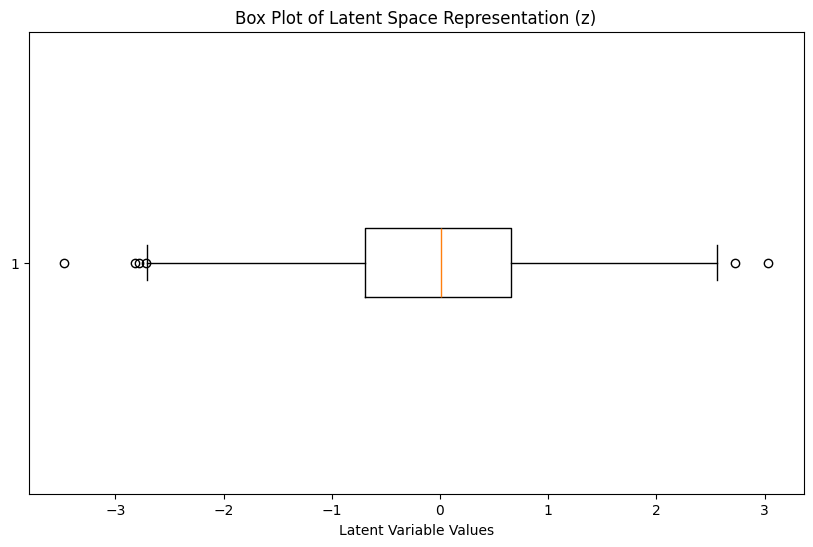

In [72]:
plt.figure(figsize=(10, 6))
plt.boxplot(z[1].cpu().detach().numpy(), vert=False)
plt.title('Box Plot of Latent Space Representation (z)')
plt.xlabel('Latent Variable Values')
plt.show()

## Testing

In [92]:
Generated_images = vae.Decode(z, img_size, apply_sigmoid=True).cpu().detach()

In [93]:
Generated_images.min(), Generated_images.max()

(tensor(2.0131e-18), tensor(0.9984))

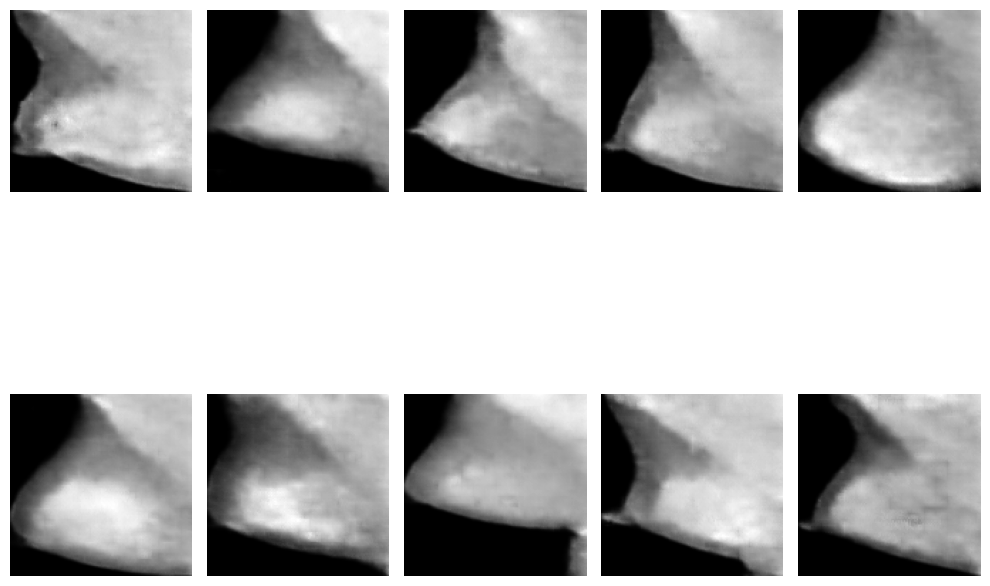

In [105]:
num_rows = 2
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10)) # Adjust figsize as needed

random_indices = np.random.choice(Generated_images.shape[0], (num_rows * num_cols), replace=False)

for i, index in enumerate(random_indices):
    row = i // num_cols
    col = i % num_cols
    image = Generated_images[index, 0, :, :]
    axes[row, col].imshow(image, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()